In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform, cosine
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
import networkx as nx
import random
import math
from collections import Counter, defaultdict
import warnings

# Настройки отображения
plt.style.use('seaborn-whitegrid')
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/osinovskov/miniconda3/envs/lenta/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/osinovskov/miniconda3/envs/lenta/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Часть 1: Загрузка и подготовка данных

In [2]:
# Загрузка данных MovieLens (маленький датасет)
# Скачать данные можно по ссылке: https://grouplens.org/datasets/movielens/

# Загрузим рейтинги
ratings = pd.read_csv('ml-32m/ratings.csv')
print("Данные о рейтингах:")
print(ratings.head())
print(f"Всего рейтингов: {len(ratings)}")

# Загрузим информацию о фильмах
movies = pd.read_csv('ml-32m/movies.csv')
print("\nДанные о фильмах:")
print(movies.head())
print(f"Всего фильмов: {len(movies)}")

# Загрузим теги фильмов (для контентного анализа)
tags = pd.read_csv('ml-32m/tags.csv')
print("\nДанные о тегах:")
print(tags.head())
print(f"Всего тегов: {len(tags)}")

Данные о рейтингах:
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858
Всего рейтингов: 32000204

Данные о фильмах:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
Всего фильмов: 87585

Данные о тегах:
   userId  movieId          tag   timestamp
0      22    26479  Kevin Klin

In [3]:
ratings.shape

(32000204, 4)

In [4]:
ratings['userId'].nunique()

200948

In [5]:
ratings = ratings[ratings['userId'] % 10 == 0]

Матрица жанров (5 первых фильмов, первые 5 жанров):
         Action  Adventure  Animation  Children  Comedy
movieId                                                
1             0          1          1         1       1
2             0          1          0         1       0
3             0          0          0         0       1
4             0          0          0         0       1
5             0          0          0         0       1


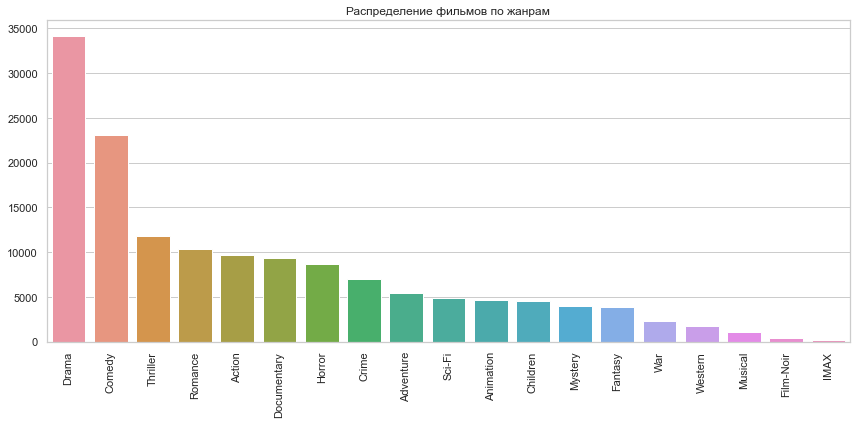

In [6]:
# Извлекаем жанры из данных
def extract_genres(movies_df):
    # Создаем DataFrame с бинарными признаками по жанрам
    genres_list = []
    for genres in movies_df['genres'].str.split('|'):
        genres_list.extend(genres)
    unique_genres = sorted(list(set(genres_list) - {'(no genres listed)'}))
    
    # Создаем матрицу фильм-жанр
    genre_matrix = np.zeros((len(movies_df), len(unique_genres)), dtype=np.int8)
    
    for i, genres in enumerate(movies_df['genres'].str.split('|')):
        for genre in genres:
            if genre != '(no genres listed)':
                genre_idx = unique_genres.index(genre)
                genre_matrix[i, genre_idx] = 1
    
    return pd.DataFrame(genre_matrix, index=movies_df['movieId'], columns=unique_genres)

# Создаем матрицу жанров
genre_df = extract_genres(movies)
print("Матрица жанров (5 первых фильмов, первые 5 жанров):")
print(genre_df.iloc[:5, :5])

# Визуализируем распределение жанров
plt.figure(figsize=(12, 6))
genre_counts = genre_df.sum().sort_values(ascending=False)
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=90)
plt.title('Распределение фильмов по жанрам')
plt.tight_layout()
plt.show()

# Часть 2: Построение базовой коллаборативной рекомендательной системы
Создадим простую рекомендательную систему на основе коллаборативной фильтрации.

In [7]:
# Создаем матрицу рейтингов пользователь-фильм
def create_rating_matrix(ratings_df, movies_df):
    # Создаем сводную таблицу пользователь-фильм
    rating_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating')
    
    # Добавляем информацию о названиях фильмов
    movie_titles = movies_df.set_index('movieId')['title']
    
    return rating_matrix, movie_titles

# Получаем матрицу рейтингов
rating_matrix, movie_titles = create_rating_matrix(ratings, movies)
print("Матрица рейтингов (фрагмент):")
print(rating_matrix.iloc[:5, :5])
print(f"Размерность матрицы: {rating_matrix.shape}")


Матрица рейтингов (фрагмент):
movieId    1    2   3   4   5
userId                       
10       2.5  2.0 NaN NaN NaN
20       5.0  NaN NaN NaN NaN
30       NaN  NaN NaN NaN NaN
40       NaN  NaN NaN NaN NaN
50       NaN  NaN NaN NaN NaN
Размерность матрицы: (20094, 40032)


In [8]:
# Функция для расчета сходства пользователей
def compute_user_similarity(rating_matrix):
    # Заполняем пропуски средними значениями по пользователям
    user_mean = rating_matrix.mean(axis=1)
    rating_matrix_filled = rating_matrix.fillna(0)
    
    # Вычисляем попарное косинусное сходство
    similarity = cosine_similarity(rating_matrix_filled)
    similarity_df = pd.DataFrame(similarity, 
                                 index=rating_matrix.index, 
                                 columns=rating_matrix.index)
    return similarity_df

# Расчет сходства пользователей
user_similarity = compute_user_similarity(rating_matrix)
print("\nМатрица сходства пользователей (фрагмент):")
print(user_similarity.iloc[:5, :5])




Матрица сходства пользователей (фрагмент):
userId        10        20        30        40        50
userId                                                  
10      1.000000  0.304778  0.152774  0.090589  0.161861
20      0.304778  1.000000  0.078798  0.180938  0.296811
30      0.152774  0.078798  1.000000  0.052198  0.000000
40      0.090589  0.180938  0.052198  1.000000  0.174905
50      0.161861  0.296811  0.000000  0.174905  1.000000


In [9]:
# Функция для получения рекомендаций на основе коллаборативной фильтрации
def get_cf_recommendations(user_id, rating_matrix, similarity_matrix, k=10, n=10):
    """
    Генерация рекомендаций для пользователя на основе k ближайших соседей
    
    Args:
        user_id: ID пользователя
        rating_matrix: Матрица рейтингов пользователь-фильм
        similarity_matrix: Матрица сходства пользователей
        k: Количество соседей для рассмотрения
        n: Количество рекомендаций для возврата
    
    Returns:
        DataFrame с рекомендованными фильмами и их предсказанными оценками
    """
    # Если пользователя нет в данных
    if user_id not in rating_matrix.index:
        return pd.DataFrame()
    
    # Выбираем k наиболее похожих пользователей
    user_similarities = similarity_matrix.loc[user_id].drop(user_id)
    top_k_users = user_similarities.nlargest(k).index
    
    # Фильмы, которые пользователь еще не оценил
    user_ratings = rating_matrix.loc[user_id]
    unrated_movies = user_ratings[user_ratings.isna()].index
    
    # Предсказываем рейтинги для неоцененных фильмов
    predicted_ratings = {}
    
    for movie_id in unrated_movies:
        # Пользователи, оценившие этот фильм
        users_rated = rating_matrix[movie_id].dropna().index
        # Пересечение с топ-k пользователями
        relevant_users = set(top_k_users) & set(users_rated)
        
        if len(relevant_users) > 0:
            # Взвешенная сумма рейтингов
            weighted_sum = 0
            similarity_sum = 0
            
            for other_user in relevant_users:
                sim = similarity_matrix.loc[user_id, other_user]
                weighted_sum += sim * rating_matrix.loc[other_user, movie_id]
                similarity_sum += abs(sim)
            
            if similarity_sum > 0:
                predicted_ratings[movie_id] = weighted_sum / similarity_sum
    
    print("Сортируем и возвращаем топ-n рекомендаций")
    recommendations = pd.DataFrame(predicted_ratings.items(), columns=['movieId', 'predicted_rating'])
    recommendations = recommendations.sort_values('predicted_rating', ascending=False).head(n)
    
    return recommendations

# Получаем рекомендации для тестового пользователя
test_user_id = 1000  # Выберем первого пользователя для примера
cf_recommendations = get_cf_recommendations(test_user_id, rating_matrix, user_similarity, k=20, n=50)

# # Добавим информацию о фильмах
cf_recommendations = cf_recommendations.merge(movies, on='movieId')
print("\nТоп-50 рекомендаций для пользователя", test_user_id)
print(cf_recommendations[['title', 'genres', 'predicted_rating']])

Сортируем и возвращаем топ-n рекомендаций

Топ-50 рекомендаций для пользователя 1000
                                                title  \
0                    James and the Giant Peach (1996)   
1                                  Primal Fear (1996)   
2                     Star Trek: First Contact (1996)   
3           Star Wars: Episode IV - A New Hope (1977)   
4                                   Phenomenon (1996)   
5                              Time to Kill, A (1996)   
6                                     Daylight (1996)   
7                                         Fear (1996)   
8      Mystery Science Theater 3000: The Movie (1996)   
9                               101 Dalmatians (1996)   
10                            Frighteners, The (1996)   
11                                Chamber, The (1996)   
12  Star Wars: Episode VI - Return of the Jedi (1983)   
13                Hunchback of Notre Dame, The (1996)   
14                            Mighty Aphrodite (1995)   
15 

In [10]:
top_k = 5

# Часть 3: Измерение разнообразия рекомендаций
В этом разделе мы реализуем различные метрики для измерения разнообразия полученных рекомендаций.

In [11]:
# 1. Внутрисписочное разнообразие (Intra-List Diversity, ILD)
def calculate_ild(recommendations, genre_matrix, metric='cosine'):
    """
    Расчет внутрисписочного разнообразия рекомендаций
    на основе жанрового распределения фильмов
    
    Args:
        recommendations: DataFrame с рекомендациями
        genre_matrix: Матрица жанров фильмов
        metric: Метрика расстояния ('cosine', 'jaccard', etc.)
    
    Returns:
        Значение внутрисписочного разнообразия
    """
    movie_ids = recommendations['movieId'].values
    
    # Если в рекомендациях менее 2 фильмов, разнообразие определить нельзя
    if len(movie_ids) < 2:
        return 0
    
    # Получаем жанровые векторы для рекомендованных фильмов
    genre_vectors = genre_matrix.loc[movie_ids].values

#     print("genre_vectors", genre_vectors, genre_vectors.shape)
    
    # Вычисляем попарные расстояния
    distances = pdist(genre_vectors, metric=metric)
    distances = np.nan_to_num(distances, nan=0)
    
#     print("distances", distances, distances.shape)
    
    # Среднее расстояние - показатель разнообразия
    return np.mean(distances)

# Рассчитаем ILD для наших рекомендаций
ild_score = calculate_ild(cf_recommendations[:top_k], genre_df)
print(f"Внутрисписочное разнообразие (ILD): {ild_score:.4f}")



Внутрисписочное разнообразие (ILD): 0.8049


In [12]:
cf_recommendations[:top_k]

,movieId,predicted_rating,title,genres
0,661,5.000000,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical
1,628,4.394842,Primal Fear (1996),Crime|Drama|Mystery|Thriller
2,1356,4.319150,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller
3,260,4.281246,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,802,4.258421,Phenomenon (1996),Drama|Romance


In [13]:
# 2. Категориальное покрытие (Genre Coverage)
def calculate_genre_coverage(recommendations, genre_matrix, movies_df):
    """
    Расчет покрытия жанров в рекомендациях
    
    Args:
        recommendations: DataFrame с рекомендациями
        genre_matrix: Матрица жанров фильмов
        movies_df: DataFrame с информацией о фильмах
    
    Returns:
        Доля всех жанров, представленных в рекомендациях
    """
    movie_ids = recommendations['movieId'].values
    
    # Получаем жанры рекомендованных фильмов
    recommended_genres = set()
    for idx in movie_ids:
        movie_genres = movies_df.loc[movies_df['movieId'] == idx, 'genres'].values[0].split('|')
        recommended_genres.update(movie_genres)
    
    # Получаем все уникальные жанры в датасете
    all_genres = set()
    for genres in movies_df['genres'].str.split('|'):
        all_genres.update(genres)
    
    # Исключаем "(no genres listed)"
    if '(no genres listed)' in all_genres:
        all_genres.remove('(no genres listed)')
    if '(no genres listed)' in recommended_genres:
        recommended_genres.remove('(no genres listed)')
    
    # Рассчитываем покрытие
    coverage = len(recommended_genres) / len(all_genres)
    
    return coverage, recommended_genres, all_genres

# Вычисляем покрытие жанров
genre_coverage, recommended_genres, all_genres = calculate_genre_coverage(cf_recommendations[:top_k], genre_df, movies)
print(f"Покрытие жанров: {genre_coverage:.4f} ({len(recommended_genres)}/{len(all_genres)})")
print(f"Представленные жанры: {', '.join(recommended_genres)}")

Покрытие жанров: 0.6316 (12/19)
Представленные жанры: Adventure, Thriller, Crime, Fantasy, Animation, Action, Musical, Sci-Fi, Children, Romance, Mystery, Drama


Энтропия распределения жанров: 3.4613


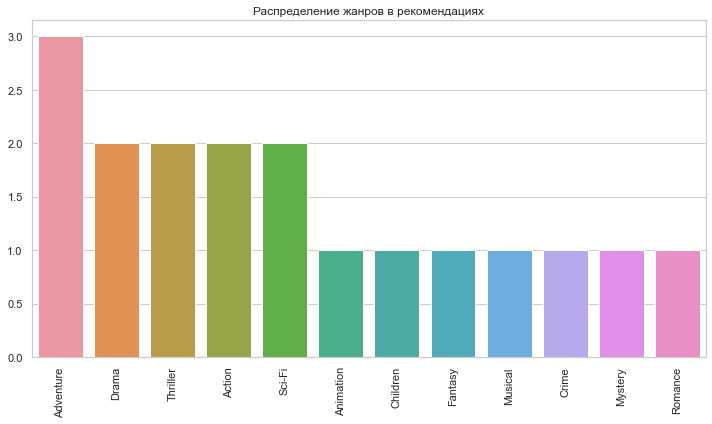

In [14]:
# 3. Энтропия распределения жанров
def calculate_genre_entropy(recommendations, movies_df):
    """
    Расчет энтропии распределения жанров в рекомендациях
    
    Args:
        recommendations: DataFrame с рекомендациями
        movies_df: DataFrame с информацией о фильмах
    
    Returns:
        Значение энтропии распределения жанров
    """
    movie_ids = recommendations['movieId'].values
    
    # Подсчитываем частоту каждого жанра в рекомендациях
    genre_counts = Counter()
    for idx in movie_ids:
        movie_genres = movies_df.loc[movies_df['movieId'] == idx, 'genres'].values[0].split('|')
        genre_counts.update(movie_genres)
    
    # Исключаем "(no genres listed)"
    if '(no genres listed)' in genre_counts:
        del genre_counts['(no genres listed)']
    
    # Рассчитываем энтропию
    total_genres = sum(genre_counts.values())
    entropy = 0
    
    for count in genre_counts.values():
        prob = count / total_genres
        entropy -= prob * math.log(prob, 2)
    
    return entropy, genre_counts

# Вычисляем энтропию жанров
genre_entropy, genre_counts = calculate_genre_entropy(cf_recommendations[:top_k], movies)
print(f"Энтропия распределения жанров: {genre_entropy:.4f}")

# Визуализируем распределение жанров в рекомендациях
plt.figure(figsize=(10, 6))
genres, counts = zip(*sorted(genre_counts.items(), key=lambda x: x[1], reverse=True))
sns.barplot(x=list(genres), y=list(counts))
plt.xticks(rotation=90)
plt.title('Распределение жанров в рекомендациях')
plt.tight_layout()
plt.show()


Неожиданность рекомендаций: 0.5500


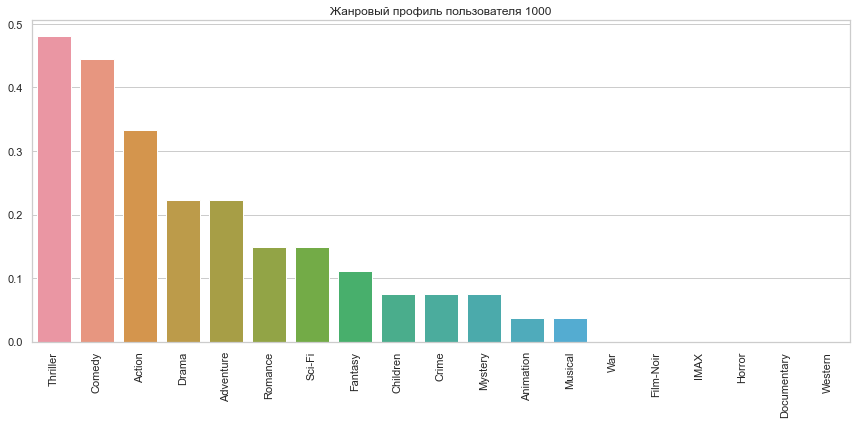

In [15]:
# 4. Неожиданность (Unexpectedness) рекомендаций
def calculate_unexpectedness(recommendations, user_id, rating_matrix, movies_df, genre_matrix):
    """
    Расчет неожиданности рекомендаций на основе отличия от исторических предпочтений пользователя
    
    Args:
        recommendations: DataFrame с рекомендациями
        user_id: ID пользователя
        rating_matrix: Матрица рейтингов пользователь-фильм
        movies_df: DataFrame с информацией о фильмах
        genre_matrix: Матрица жанров фильмов
    
    Returns:
        Значение неожиданности рекомендаций
    """
    # Получаем фильмы, которые пользователь уже оценил
    rated_movies = rating_matrix.loc[user_id].dropna().index
    
    # Средний жанровый профиль пользователя на основе оцененных фильмов
    if len(rated_movies) > 0:
        user_genre_profile = genre_matrix.loc[rated_movies].mean(axis=0)
    else:
        # Если пользователь еще ничего не оценил
        return 0, np.zeros(genre_matrix.shape[1])
    
    # Жанровые векторы рекомендованных фильмов
    recommended_movies = recommendations['movieId'].values
    recommended_genre_vectors = genre_matrix.loc[recommended_movies]
    
    # Вычисляем расстояние (неожиданность) для каждой рекомендации
    unexpectedness_scores = []
    for _, row in recommended_genre_vectors.iterrows():
        # Косинусное расстояние от жанрового профиля пользователя
        unexpectedness = cosine(row, user_genre_profile)
        unexpectedness_scores.append(unexpectedness)
    
    # Средняя неожиданность рекомендаций
    avg_unexpectedness = np.mean(unexpectedness_scores)
    
    return avg_unexpectedness, user_genre_profile

# Вычисляем неожиданность рекомендаций
unexpectedness, user_genre_profile = calculate_unexpectedness(
    cf_recommendations[:top_k], test_user_id, rating_matrix, movies, genre_df)
print(f"Неожиданность рекомендаций: {unexpectedness:.4f}")

# Визуализируем жанровый профиль пользователя
plt.figure(figsize=(12, 6))
sorted_genres = user_genre_profile.sort_values(ascending=False)
sns.barplot(x=sorted_genres.index, y=sorted_genres.values)
plt.xticks(rotation=90)
plt.title(f'Жанровый профиль пользователя {test_user_id}')
plt.tight_layout()
plt.show()

Средняя популярность рекомендаций: 2907.60 оценок
Средняя популярность всех фильмов: 78.93 оценок
Соотношение популярности рекомендаций к среднему: 36.84x


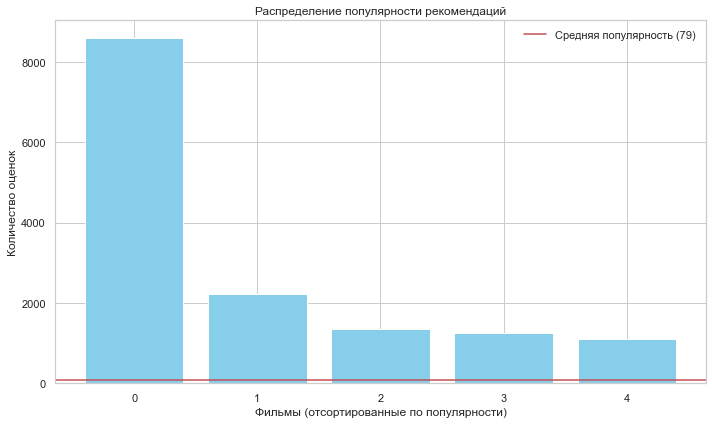

In [16]:
# 5. Анализ популярности рекомендаций
def analyze_popularity_bias(recommendations, ratings_df):
    """
    Анализ смещения в сторону популярных фильмов в рекомендациях
    
    Args:
        recommendations: DataFrame с рекомендациями
        ratings_df: DataFrame с рейтингами
    
    Returns:
        Средняя популярность рекомендованных фильмов и распределение
    """
    # Рассчитываем популярность каждого фильма (количество оценок)
    movie_popularity = ratings_df['movieId'].value_counts()
    
    # Популярность рекомендованных фильмов
    recommended_popularity = []
    for movie_id in recommendations['movieId']:
        popularity = movie_popularity.get(movie_id, 0)
        recommended_popularity.append(popularity)
    
    # Средняя популярность рекомендаций
    avg_popularity = np.mean(recommended_popularity)
    
    # Общая средняя популярность фильмов
    overall_avg_popularity = movie_popularity.mean()
    
    return avg_popularity, overall_avg_popularity, recommended_popularity

# Анализ популярности рекомендаций
avg_pop, overall_avg_pop, pop_distribution = analyze_popularity_bias(cf_recommendations[:top_k], ratings)
print(f"Средняя популярность рекомендаций: {avg_pop:.2f} оценок")
print(f"Средняя популярность всех фильмов: {overall_avg_pop:.2f} оценок")
print(f"Соотношение популярности рекомендаций к среднему: {avg_pop/overall_avg_pop:.2f}x")

# Визуализируем распределение популярности рекомендаций
plt.figure(figsize=(10, 6))
plt.bar(range(len(pop_distribution)), sorted(pop_distribution, reverse=True), color='skyblue')
plt.axhline(y=overall_avg_pop, color='r', linestyle='-', label=f'Средняя популярность ({overall_avg_pop:.0f})')
plt.title('Распределение популярности рекомендаций')
plt.xlabel('Фильмы (отсортированные по популярности)')
plt.ylabel('Количество оценок')
plt.legend()
plt.tight_layout()
plt.show()

# Часть 4: Методы увеличения разнообразия рекомендаций 


Результаты для λ = 0.9:
Внутрисписочное разнообразие (ILD): 0.7612
Энтропия жанров: 3.4104
Неожиданность: 0.5284

Результаты для λ = 0.95:
Внутрисписочное разнообразие (ILD): 0.8049
Энтропия жанров: 3.4613
Неожиданность: 0.5500

Результаты для λ = 0.99:
Внутрисписочное разнообразие (ILD): 0.8049
Энтропия жанров: 3.4613
Неожиданность: 0.5500

Результаты для λ = 1.0:
Внутрисписочное разнообразие (ILD): 0.8049
Энтропия жанров: 3.4613
Неожиданность: 0.5500


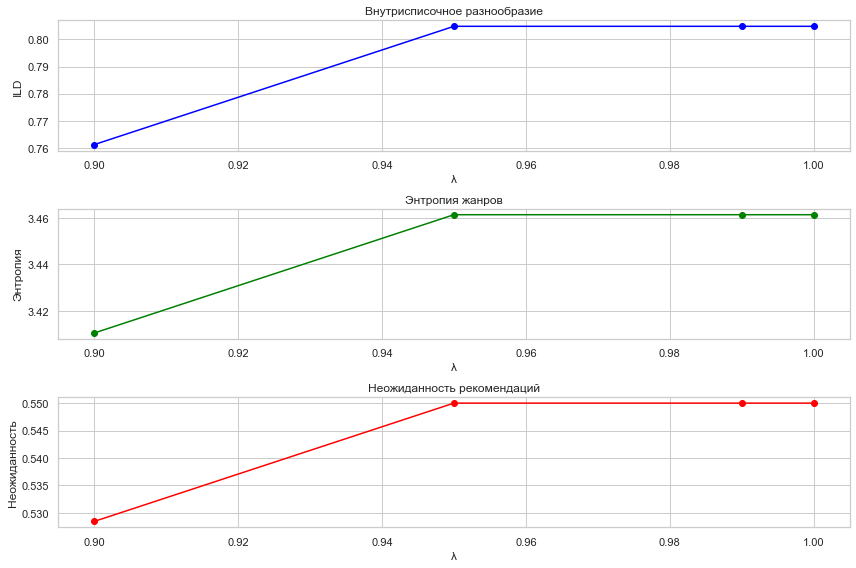

In [17]:
# 1. Реализация метода максимальной маржинальной релевантности (MMR)
def diversity_based_reranking_mmr(recommendations, genre_matrix, lambda_param=0.5, metric='cosine', top_k=5):
    """
    Переранжирование рекомендаций с использованием метода MMR
    для увеличения разнообразия
    
    Args:
        recommendations: DataFrame с рекомендациями и предсказанными оценками
        genre_matrix: Матрица жанров фильмов
        lambda_param: Параметр, контролирующий баланс между релевантностью и разнообразием (0-1)
        metric: Метрика расстояния для оценки разнообразия
    
    Returns:
        DataFrame с переранжированными рекомендациями
    """
    # Копируем исходные рекомендации
    original_recs = recommendations.copy()
    
    # Получаем жанровые векторы для рекомендованных фильмов
    movie_ids = original_recs['movieId'].values
    movie_genre_vectors = genre_matrix.loc[movie_ids].values
    
    # Нормализуем предсказанные оценки (релевантность) к [0, 1]
    relevance_scores = original_recs['predicted_rating'].values
    min_rel, max_rel = np.min(relevance_scores), np.max(relevance_scores)
    if max_rel > min_rel:
        relevance_scores = (relevance_scores - min_rel) / (max_rel - min_rel)
    else:
        relevance_scores = np.ones_like(relevance_scores)
    
    # Инициализируем списки для переранжированных рекомендаций
    reranked_indices = []
    remaining_indices = list(range(len(movie_ids)))
    
    # Выбираем первый элемент с максимальной релевантностью
    first_idx = np.argmax(relevance_scores)
    reranked_indices.append(first_idx)
    remaining_indices.remove(first_idx)
    
    # Итеративно выбираем остальные элементы
    while remaining_indices:
        mmr_scores = []
        
        for idx in remaining_indices:
            # Релевантность элемента
            rel_score = relevance_scores[idx]
            
            # Максимальное сходство с уже выбранными элементами (разнообразие)
            max_sim = 0
            for selected_idx in reranked_indices:
                # Вычисляем сходство (1 - расстояние) между жанровыми векторами
                sim = 1 - pairwise_distances(
                    movie_genre_vectors[idx].reshape(1, -1), 
                    movie_genre_vectors[selected_idx].reshape(1, -1), 
                    metric=metric
                )[0][0]
                max_sim = max(max_sim, sim)
            
            # MMR = λ * rel - (1-λ) * max_sim
            mmr_score = lambda_param * rel_score - (1 - lambda_param) * max_sim
            mmr_scores.append(mmr_score)
        
        # Выбираем элемент с максимальным MMR
        next_idx = remaining_indices[np.argmax(mmr_scores)]
        reranked_indices.append(next_idx)
        remaining_indices.remove(next_idx)
    
    # Создаем переранжированный DataFrame
    reranked_recs = original_recs.iloc[reranked_indices].reset_index(drop=True)
    
    return reranked_recs[:top_k]

# Применяем MMR с различными значениями параметра λ
lambda_values = [0.9, 0.95, 0.99, 1.0]  # 1.0 соответствует исходному ранжированию
reranked_results = {}

for lambda_val in lambda_values:
    reranked = diversity_based_reranking_mmr(cf_recommendations, genre_df, lambda_param=lambda_val)
    reranked_results[lambda_val] = reranked
    
    # Вычисляем метрики разнообразия для переранжированного списка
    ild = calculate_ild(reranked, genre_df)
    entropy, _ = calculate_genre_entropy(reranked, movies)
    unexpectedness_score, _ = calculate_unexpectedness(reranked, test_user_id, rating_matrix, movies, genre_df)
    
    print(f"\nРезультаты для λ = {lambda_val}:")
    print(f"Внутрисписочное разнообразие (ILD): {ild:.4f}")
    print(f"Энтропия жанров: {entropy:.4f}")
    print(f"Неожиданность: {unexpectedness_score:.4f}")

# Визуализируем изменение разнообразия в зависимости от λ
ild_values = [calculate_ild(reranked_results[l], genre_df) for l in lambda_values]
entropy_values = [calculate_genre_entropy(reranked_results[l], movies)[0] for l in lambda_values]
unexpectedness_values = [calculate_unexpectedness(reranked_results[l], test_user_id, 
                                               rating_matrix, movies, genre_df)[0] for l in lambda_values]

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(lambda_values, ild_values, 'o-', color='blue')
plt.xlabel('λ')
plt.ylabel('ILD')
plt.title('Внутрисписочное разнообразие')

plt.subplot(3, 1, 2)
plt.plot(lambda_values, entropy_values, 'o-', color='green')
plt.xlabel('λ')
plt.ylabel('Энтропия')
plt.title('Энтропия жанров')

plt.subplot(3, 1, 3)
plt.plot(lambda_values, unexpectedness_values, 'o-', color='red')
plt.xlabel('λ')
plt.ylabel('Неожиданность')
plt.title('Неожиданность рекомендаций')

plt.tight_layout()
plt.show()

In [18]:
reranked_results

{0.9:    movieId  predicted_rating                             title  \
 0      661          5.000000  James and the Giant Peach (1996)   
 1      628          4.394842                Primal Fear (1996)   
 2     1356          4.319150   Star Trek: First Contact (1996)   
 3      802          4.258421                 Phenomenon (1996)   
 4      805          4.254152            Time to Kill, A (1996)   
 
                                          genres  
 0  Adventure|Animation|Children|Fantasy|Musical  
 1                  Crime|Drama|Mystery|Thriller  
 2              Action|Adventure|Sci-Fi|Thriller  
 3                                 Drama|Romance  
 4                                Drama|Thriller  ,
 0.95:    movieId  predicted_rating                                      title  \
 0      661          5.000000           James and the Giant Peach (1996)   
 1      628          4.394842                         Primal Fear (1996)   
 2     1356          4.319150            Star Trek


Рекомендации с применением кластеризации:
                                       title  \
0           James and the Giant Peach (1996)   
1                         Primal Fear (1996)   
2            Star Trek: First Contact (1996)   
3  Star Wars: Episode IV - A New Hope (1977)   
4                          Phenomenon (1996)   

                                         genres  predicted_rating  
0  Adventure|Animation|Children|Fantasy|Musical          5.000000  
1                  Crime|Drama|Mystery|Thriller          4.394842  
2              Action|Adventure|Sci-Fi|Thriller          4.319150  
3                       Action|Adventure|Sci-Fi          4.281246  
4                                 Drama|Romance          4.258421  

Метрики разнообразия для рекомендаций на основе кластеризации:
Внутрисписочное разнообразие (ILD): 0.8049
Энтропия жанров: 3.4613
Неожиданность: 0.5500
Покрытие жанров: 0.6316


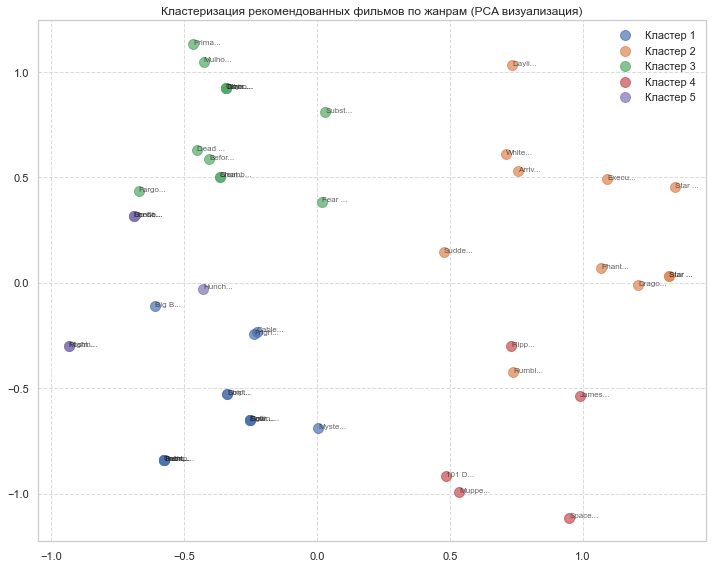

In [19]:
# 2. Реализация метода кластеризации для разнообразия
def diversity_through_clustering(recommendations, genre_matrix, n_clusters=4, n_per_cluster=2):
    """
    Увеличение разнообразия рекомендаций путем кластеризации фильмов
    и выбора элементов из разных кластеров
    
    Args:
        recommendations: DataFrame с исходными рекомендациями
        genre_matrix: Матрица жанров фильмов
        n_clusters: Количество кластеров
        n_per_cluster: Количество фильмов, выбираемых из каждого кластера
    
    Returns:
        DataFrame с диверсифицированными рекомендациями
    """
    # Получаем больше исходных рекомендаций для кластеризации
    original_recs = recommendations.copy()
    n_total = n_clusters * n_per_cluster
    
    if len(original_recs) < n_total:
        print(f"Предупреждение: недостаточно рекомендаций ({len(original_recs)}) для запрошенных параметров")
        n_clusters = min(n_clusters, len(original_recs))
        n_per_cluster = min(n_per_cluster, len(original_recs) // n_clusters)
        n_total = n_clusters * n_per_cluster
    
    # Получаем жанровые векторы для рекомендованных фильмов
    movie_ids = original_recs['movieId'].values
    movie_genre_vectors = genre_matrix.loc[movie_ids].values
    
    # Применяем кластеризацию K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(movie_genre_vectors)
    
    # Добавляем кластер в оригинальные рекомендации
    original_recs['cluster'] = clusters
    
    # Выбираем фильмы из каждого кластера
    diversified_recs = pd.DataFrame()
    
    for cluster_id in range(n_clusters):
        cluster_recs = original_recs[original_recs['cluster'] == cluster_id]
        
        if len(cluster_recs) > 0:
            # Берем top-n фильмов из кластера (по предсказанной оценке)
            top_from_cluster = cluster_recs.nlargest(n_per_cluster, 'predicted_rating')
            diversified_recs = pd.concat([diversified_recs, top_from_cluster])
    
    # Сортируем финальные рекомендации по предсказанной оценке
    diversified_recs = diversified_recs.sort_values('predicted_rating', ascending=False)
    diversified_recs = diversified_recs.drop('cluster', axis=1).reset_index(drop=True)
    
    return diversified_recs

# Применяем метод кластеризации
cluster_diverse_recs = diversity_through_clustering(cf_recommendations, genre_df, 
                                                 n_clusters=5, n_per_cluster=2)[:top_k]
print("\nРекомендации с применением кластеризации:")
print(cluster_diverse_recs[['title', 'genres', 'predicted_rating']])

# Вычисляем метрики разнообразия для рекомендаций на основе кластеризации
# Вычисляем метрики разнообразия для рекомендаций на основе кластеризации
ild_cluster = calculate_ild(cluster_diverse_recs, genre_df)
entropy_cluster, _ = calculate_genre_entropy(cluster_diverse_recs, movies)
unexpectedness_cluster, _ = calculate_unexpectedness(cluster_diverse_recs, test_user_id, rating_matrix, movies, genre_df)
coverage_cluster, _, _ = calculate_genre_coverage(cluster_diverse_recs, genre_df, movies)

print(f"\nМетрики разнообразия для рекомендаций на основе кластеризации:")
print(f"Внутрисписочное разнообразие (ILD): {ild_cluster:.4f}")
print(f"Энтропия жанров: {entropy_cluster:.4f}")
print(f"Неожиданность: {unexpectedness_cluster:.4f}")
print(f"Покрытие жанров: {coverage_cluster:.4f}")

# Визуализируем кластеры фильмов
# Применим PCA для визуализации в 2D пространстве
movie_ids = cf_recommendations['movieId'].values
movie_genre_vectors = genre_df.loc[movie_ids].values

# Применяем PCA для снижения размерности
pca = PCA(n_components=2)
genre_2d = pca.fit_transform(movie_genre_vectors)

# Кластеризуем данные
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(movie_genre_vectors)

# Визуализируем кластеры
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.scatter(genre_2d[clusters == i, 0], genre_2d[clusters == i, 1], 
                label=f'Кластер {i+1}', s=100, alpha=0.7)

# Добавляем названия фильмов
for i, (x, y) in enumerate(genre_2d):
    plt.annotate(cf_recommendations['title'].iloc[i][:top_k] + '...', 
                (x, y), fontsize=8, alpha=0.7)

plt.title('Кластеризация рекомендованных фильмов по жанрам (PCA визуализация)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
cf_recommendations[:top_k]

,movieId,predicted_rating,title,genres
0,661,5.000000,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical
1,628,4.394842,Primal Fear (1996),Crime|Drama|Mystery|Thriller
2,1356,4.319150,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller
3,260,4.281246,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,802,4.258421,Phenomenon (1996),Drama|Romance


In [21]:
# 3. Реализация вероятностного подхода (Determinantal Point Process)
def simulate_dpp(recommendations, genre_matrix, k=5):
    """
    Симуляция детерминантного точечного процесса (DPP) для выбора разнообразного 
    подмножества рекомендаций
    
    Args:
        recommendations: DataFrame с исходными рекомендациями
        genre_matrix: Матрица жанров фильмов
        k: Желаемое количество рекомендаций
    
    Returns:
        DataFrame с диверсифицированными рекомендациями
    """
    original_recs = recommendations.copy()
    
    if len(original_recs) <= k:
        return original_recs
    
    # Получаем жанровые векторы для рекомендованных фильмов
    movie_ids = original_recs['movieId'].values
    movie_genre_vectors = genre_matrix.loc[movie_ids].values
    
    # Рассчитываем качество элементов (используем предсказанные оценки)
    quality = original_recs['predicted_rating'].values
    # Нормализуем качество
    quality = (quality - np.min(quality)) / (np.max(quality) - np.min(quality) + 1e-10)
    
    # Матрица ядра: комбинирует качество и разнообразие
    # Для каждой пары элементов: K(i,j) = q(i) * sim(i,j) * q(j)
    # где sim(i,j) - косинусная схожесть между элементами
    
    # Рассчитываем схожесть (косинусное сходство)
    similarity = cosine_similarity(movie_genre_vectors)
    
    # Создаем матрицу ядра (kernel matrix)
    kernel = np.zeros((len(movie_ids), len(movie_ids)))
    for i in range(len(movie_ids)):
        for j in range(len(movie_ids)):
            kernel[i, j] = quality[i] * similarity[i, j] * quality[j]
    
    # Упрощенная симуляция DPP с жадным выбором
    selected_indices = []
    remaining_indices = list(range(len(movie_ids)))
    
    # Выбираем первый элемент с наибольшим качеством
    first_idx = np.argmax(quality)
    selected_indices.append(first_idx)
    remaining_indices.remove(first_idx)
    
    # Последовательно выбираем элементы с наименьшим суммарным сходством с выбранными
    while len(selected_indices) < k and remaining_indices:
        best_idx = None
        best_score = float('-inf')
        
        for idx in remaining_indices:
            # Штраф за сходство с уже выбранными элементами
            sim_penalty = sum(kernel[idx, j] for j in selected_indices)
            # Награда за качество
            qual_reward = quality[idx] * 3  # Коэффициент для баланса между качеством и разнообразием
            # Итоговый скор
            score = qual_reward - sim_penalty
            
            if score > best_score:
                best_score = score
                best_idx = idx
        
        if best_idx is not None:
            selected_indices.append(best_idx)
            remaining_indices.remove(best_idx)
    
    # Создаем диверсифицированные рекомендации
    diverse_recs = original_recs.iloc[selected_indices].reset_index(drop=True)
    
    return diverse_recs

# Применяем DPP симуляцию
dpp_diverse_recs = simulate_dpp(cf_recommendations, genre_df, k=5)
print("\nРекомендации с применением DPP:")
print(dpp_diverse_recs[['title', 'genres', 'predicted_rating']])

# Вычисляем метрики разнообразия для рекомендаций на основе DPP
ild_dpp = calculate_ild(dpp_diverse_recs, genre_df)
entropy_dpp, _ = calculate_genre_entropy(dpp_diverse_recs, movies)
unexpectedness_dpp, _ = calculate_unexpectedness(dpp_diverse_recs, test_user_id, rating_matrix, movies, genre_df)
coverage_dpp, _, _ = calculate_genre_coverage(dpp_diverse_recs, genre_df, movies)

print(f"\nМетрики разнообразия для рекомендаций на основе DPP:")
print(f"Внутрисписочное разнообразие (ILD): {ild_dpp:.4f}")
print(f"Энтропия жанров: {entropy_dpp:.4f}")
print(f"Неожиданность: {unexpectedness_dpp:.4f}")
print(f"Покрытие жанров: {coverage_dpp:.4f}")


Рекомендации с применением DPP:
                                       title  \
0           James and the Giant Peach (1996)   
1                         Primal Fear (1996)   
2  Star Wars: Episode IV - A New Hope (1977)   
3                          Phenomenon (1996)   
4                    Frighteners, The (1996)   

                                         genres  predicted_rating  
0  Adventure|Animation|Children|Fantasy|Musical          5.000000  
1                  Crime|Drama|Mystery|Thriller          4.394842  
2                       Action|Adventure|Sci-Fi          4.281246  
3                                 Drama|Romance          4.258421  
4                        Comedy|Horror|Thriller          4.000000  

Метрики разнообразия для рекомендаций на основе DPP:
Внутрисписочное разнообразие (ILD): 0.9100
Энтропия жанров: 3.7345
Неожиданность: 0.5637
Покрытие жанров: 0.7368


In [22]:
cf_recommendations[:top_k]

,movieId,predicted_rating,title,genres
0,661,5.000000,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical
1,628,4.394842,Primal Fear (1996),Crime|Drama|Mystery|Thriller
2,1356,4.319150,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller
3,260,4.281246,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,802,4.258421,Phenomenon (1996),Drama|Romance


In [23]:
reranked_results.keys()

dict_keys([0.9, 0.95, 0.99, 1.0])


Сравнение всех методов по метрикам разнообразия:
           Метод     ILD  Энтропия  Неожиданность  Покрытие
0        Базовый  0.7260    3.4113         0.5084    0.7368
1   MMR (λ=0.99)  0.8049    3.4613         0.5500    0.6316
2  Кластеризация  0.8049    3.4613         0.5500    0.6316
3            DPP  0.9100    3.7345         0.5637    0.7368


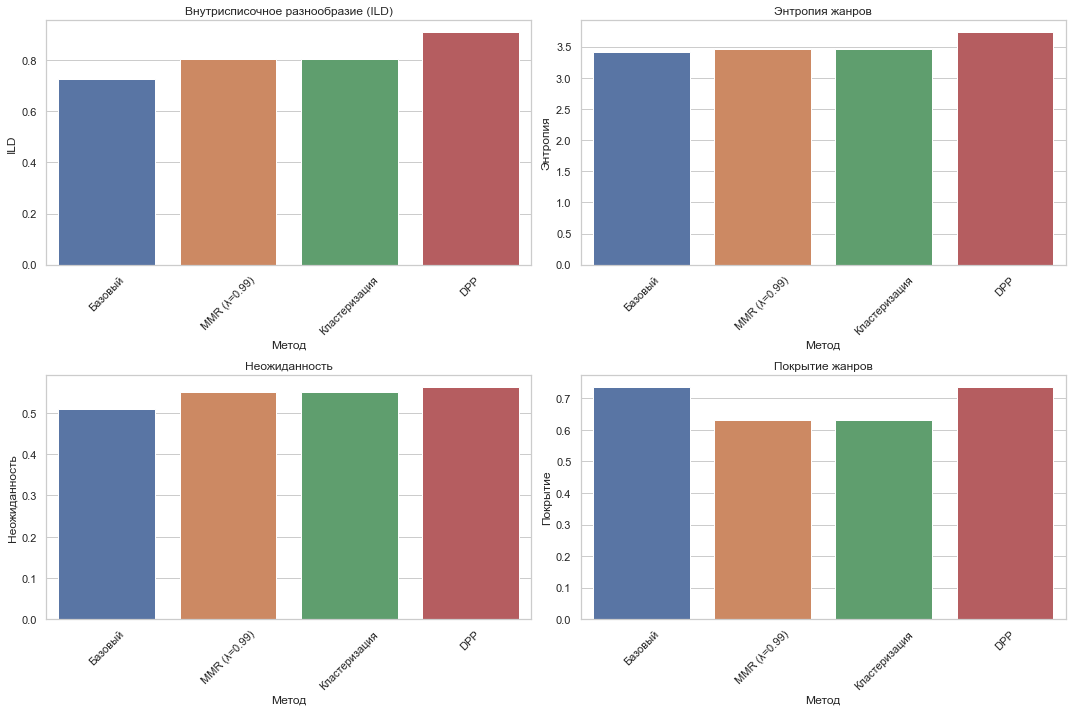

In [24]:
# Сравнение всех методов по метрикам разнообразия
methods = ['Базовый', 'MMR (λ=0.99)', 'Кластеризация', 'DPP']

# Собираем метрики
ild_scores = [
    calculate_ild(cf_recommendations, genre_df),
    calculate_ild(reranked_results[0.99], genre_df),
    ild_cluster,
    ild_dpp
]

entropy_scores = [
    calculate_genre_entropy(cf_recommendations, movies)[0],
    calculate_genre_entropy(reranked_results[0.99], movies)[0],
    entropy_cluster,
    entropy_dpp
]

unexpectedness_scores = [
    calculate_unexpectedness(cf_recommendations, test_user_id, rating_matrix, movies, genre_df)[0],
    calculate_unexpectedness(reranked_results[0.99], test_user_id, rating_matrix, movies, genre_df)[0],
    unexpectedness_cluster,
    unexpectedness_dpp
]

coverage_scores = [
    calculate_genre_coverage(cf_recommendations, genre_df, movies)[0],
    calculate_genre_coverage(reranked_results[0.99], genre_df, movies)[0],
    coverage_cluster,
    coverage_dpp
]

# Визуализация сравнения
metrics_data = pd.DataFrame({
    'Метод': methods,
    'ILD': ild_scores,
    'Энтропия': entropy_scores,
    'Неожиданность': unexpectedness_scores,
    'Покрытие': coverage_scores
})

# Отображаем таблицу со всеми метриками
print("\nСравнение всех методов по метрикам разнообразия:")
print(metrics_data.round(4))

# Визуализируем сравнение
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.barplot(x='Метод', y='ILD', data=metrics_data)
plt.title('Внутрисписочное разнообразие (ILD)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.barplot(x='Метод', y='Энтропия', data=metrics_data)
plt.title('Энтропия жанров')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.barplot(x='Метод', y='Неожиданность', data=metrics_data)
plt.title('Неожиданность')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.barplot(x='Метод', y='Покрытие', data=metrics_data)
plt.title('Покрытие жанров')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()